In [1]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

CSV_PATH = "survey_results_public.csv"  
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("CSV_PATH:", CSV_PATH)


CSV_PATH: survey_results_public.csv


In [2]:
use_cols = [
    # common SO 2025 columns
    "Country",
    "ConvertedCompYearly",  # numeric salary (USD-equivalent in SO data)
    "CompTotal",            # raw comp if ConvertedCompYearly missing
    "Currency",
    "WorkExp",              # years of professional work
    "YearsCode",            # years coding
    "RemoteWork",
    "Employment",
    "JobSat",               # satisfaction
]
df = pd.read_csv(CSV_PATH, usecols=lambda c: c in use_cols, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns found:", list(df.columns))

Loaded shape: (49123, 9)
Columns found: ['Employment', 'WorkExp', 'YearsCode', 'RemoteWork', 'Country', 'Currency', 'CompTotal', 'ConvertedCompYearly', 'JobSat']


In [3]:
# Build unified variables
df["SalaryUSD"] = pd.to_numeric(df.get("ConvertedCompYearly"), errors="coerce")
df["JobSatisfaction"] = pd.to_numeric(df.get("JobSat"), errors="coerce")

In [4]:
# Experience: prefer WorkExp; otherwise YearsCode; normalize to float
for col in ["WorkExp","YearsCode"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df["YearsCodePro"] = np.where(df["WorkExp"].notna(), df["WorkExp"], df["YearsCode"])

In [5]:
# Clean categories
for c in ["Country","RemoteWork","Employment","Currency"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

df.head()

,Employment,WorkExp,YearsCode,RemoteWork,Country,Currency,CompTotal,ConvertedCompYearly,JobSat,SalaryUSD,JobSatisfaction,YearsCodePro
0,Employed,8.0,14.0,Remote,Ukraine,EUR European Euro,52800.0,61256.0,10.0,61256.0,10.0,8.0
1,Employed,2.0,10.0,"Hybrid (some in-person, leans heavy to flexibi...",Netherlands,EUR European Euro,90000.0,104413.0,9.0,104413.0,9.0,2.0
2,"Independent contractor, freelancer, or self-em...",10.0,12.0,nan,Ukraine,UAH Ukrainian hryvnia,2214000.0,53061.0,8.0,53061.0,8.0,10.0
3,Employed,4.0,5.0,Remote,Ukraine,EUR European Euro,31200.0,36197.0,6.0,36197.0,6.0,4.0
4,"Independent contractor, freelancer, or self-em...",21.0,22.0,nan,Ukraine,USD United States dollar,60000.0,60000.0,7.0,60000.0,7.0,21.0


In [6]:
# Keep rows with both salary and satisfaction for fair comparisons
df = df.dropna(subset=["SalaryUSD","JobSatisfaction"])

In [7]:
# Filter salary to reduce extreme outliers
df = df[(df["SalaryUSD"] >= 5000) & (df["SalaryUSD"] <= 260000)]

In [8]:
# Clip experience to a plausible range
if "YearsCodePro" in df.columns:
    df["YearsCodePro"] = df["YearsCodePro"].clip(lower=0, upper=60)


In [9]:
print("After cleaning:", df.shape)
df[["SalaryUSD","YearsCodePro","JobSatisfaction"]].describe()

After cleaning: (17674, 12)


,SalaryUSD,YearsCodePro,JobSatisfaction
count,17674.000000,17662.000000,17674.000000
mean,89134.092509,13.457989,7.201143
std,55845.461955,9.535923,1.933892
min,5000.000000,1.000000,0.000000
25%,47445.000000,6.000000,6.000000
50%,80000.000000,11.000000,8.000000
75%,120000.000000,19.000000,8.000000
max,260000.000000,60.000000,10.000000


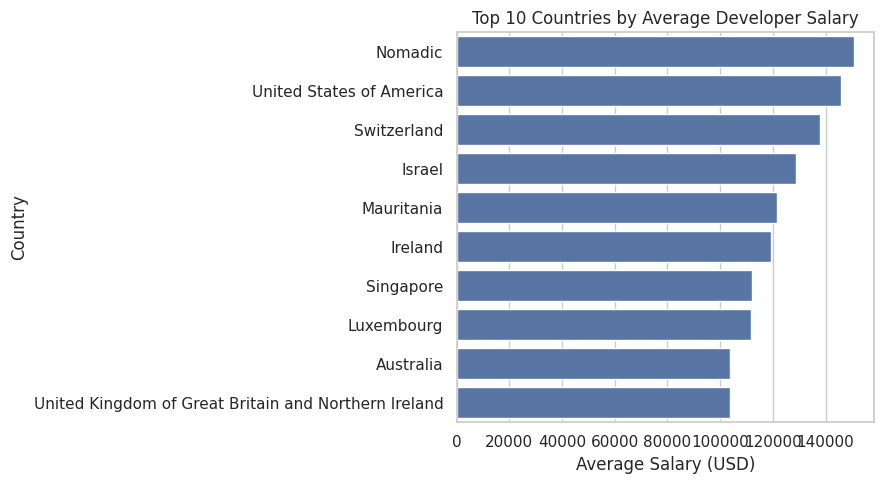

,Country,SalaryUSD
0,Nomadic,150788.571429
1,United States of America,145991.694460
2,Switzerland,137687.328947
3,Israel,128875.542857
4,Mauritania,121570.000000
5,Ireland,119229.873950
6,Singapore,112083.130435
7,Luxembourg,111683.466667
8,Australia,103770.644592
9,United Kingdom of Great Britain and Northern I...,103741.316949


In [10]:
top_countries = (
    df.groupby("Country")["SalaryUSD"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

plt.figure(figsize=(9,5))
sns.barplot(data=top_countries, x="SalaryUSD", y="Country")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Country")
plt.title("Top 10 Countries by Average Developer Salary")
plt.tight_layout()
plt.show()

top_countries


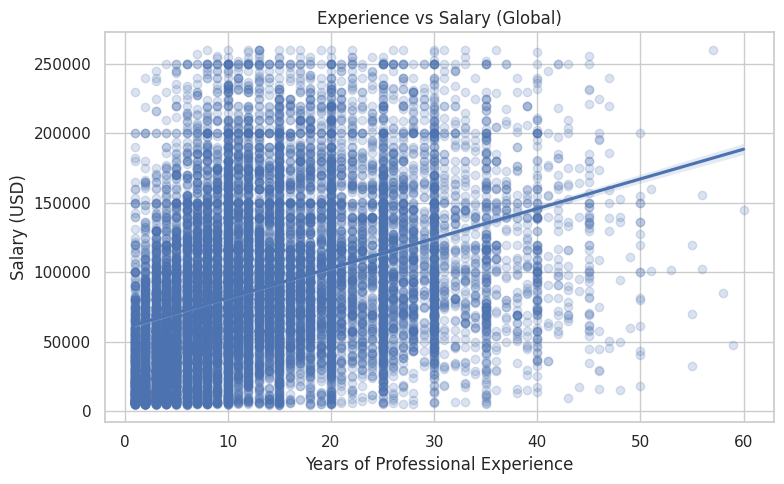

,YearsCodePro,SalaryUSD
YearsCodePro,1.000000,0.365133
SalaryUSD,0.365133,1.000000


In [11]:
df_exp = df.dropna(subset=["YearsCodePro"]).copy()

plt.figure(figsize=(8,5))
sns.regplot(data=df_exp, x="YearsCodePro", y="SalaryUSD", scatter_kws={"alpha":0.2})
plt.xlabel("Years of Professional Experience")
plt.ylabel("Salary (USD)")
plt.title("Experience vs Salary (Global)")
plt.tight_layout()
plt.show()

df_exp[["YearsCodePro","SalaryUSD"]].corr()

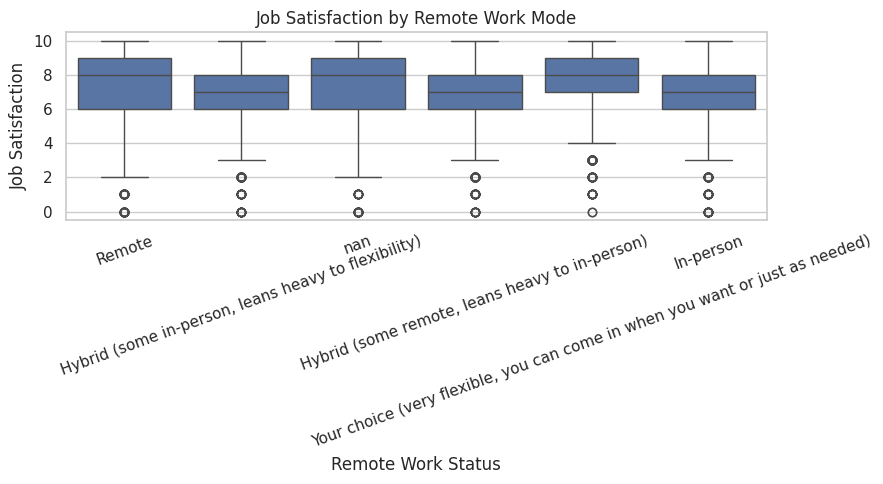

,count,mean,median
RemoteWork,,,
"Hybrid (some in-person, leans heavy to flexibility)",3007,7.186232,7.0
"Hybrid (some remote, leans heavy to in-person)",3111,7.041787,7.0
In-person,2030,6.916749,7.0
Remote,5579,7.302384,8.0
"Your choice (very flexible, you can come in when you want or just as needed)",2077,7.408281,8.0
nan,1870,7.266845,8.0


In [12]:
df_remote = df.dropna(subset=["RemoteWork"]).copy()

plt.figure(figsize=(9,5))
sns.boxplot(data=df_remote, x="RemoteWork", y="JobSatisfaction")
plt.xlabel("Remote Work Status")
plt.ylabel("Job Satisfaction")
plt.title("Job Satisfaction by Remote Work Mode")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

df_remote.groupby("RemoteWork")["JobSatisfaction"].agg(["count","mean","median"])

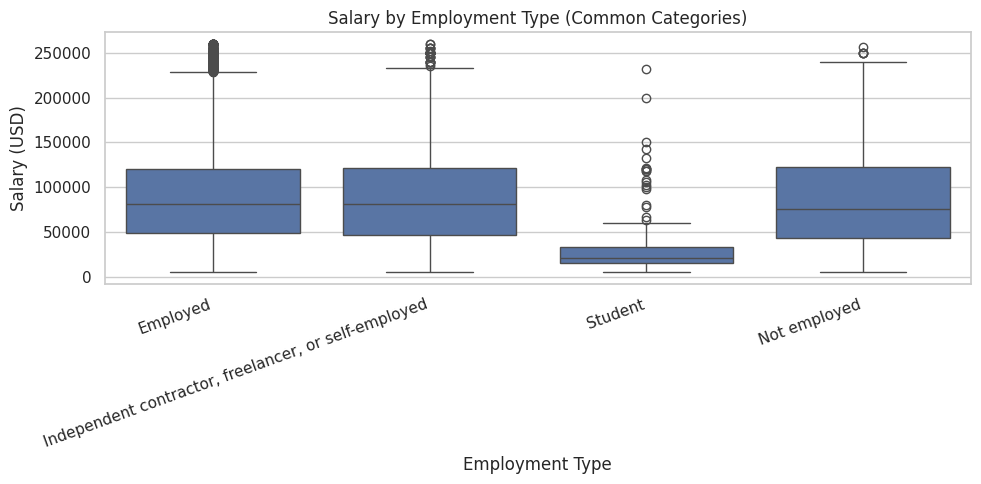

,count,median,mean
Employment,,,
Employed,14913,81210.0,89844.974117
"Independent contractor, freelancer, or self-employed",2231,81210.0,89860.974003
Not employed,278,75410.0,88675.629496
Student,209,20883.0,31745.665072


In [13]:
emp_counts = df["Employment"].value_counts()
keep_emp = emp_counts[emp_counts >= 100].index
df_emp = df[df["Employment"].isin(keep_emp)].copy()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_emp, x="Employment", y="SalaryUSD")
plt.xlabel("Employment Type")
plt.ylabel("Salary (USD)")
plt.title("Salary by Employment Type (Common Categories)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

df_emp.groupby("Employment")["SalaryUSD"].agg(["count","median","mean"]).sort_values("median", ascending=False).head(10)

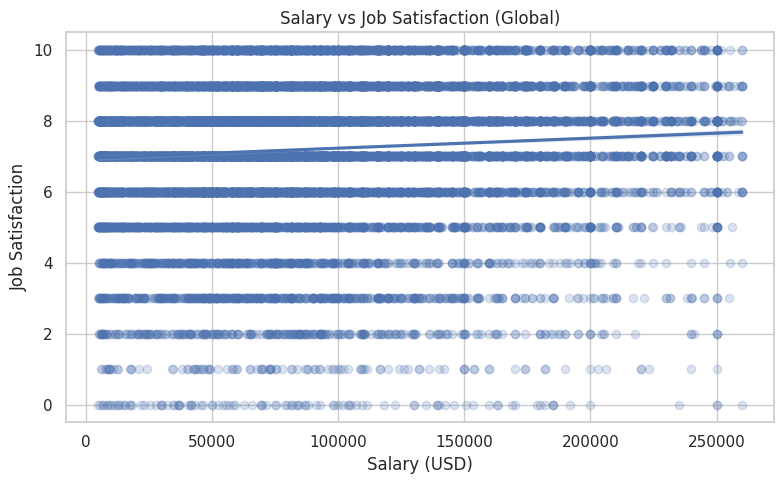

,SalaryUSD,JobSatisfaction
SalaryUSD,1.000000,0.081623
JobSatisfaction,0.081623,1.000000


In [14]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x="SalaryUSD", y="JobSatisfaction", scatter_kws={"alpha":0.2})
plt.xlabel("Salary (USD)")
plt.ylabel("Job Satisfaction")
plt.title("Salary vs Job Satisfaction (Global)")
plt.tight_layout()
plt.show()

df[["SalaryUSD","JobSatisfaction"]].corr()

In [15]:
model_cols = ["SalaryUSD", "YearsCodePro", "RemoteWork", "Employment", "Country"]
dm = df[model_cols].dropna(subset=["SalaryUSD","YearsCodePro"]).copy()

In [16]:
# Reasonable salary band
dm = dm[(dm["SalaryUSD"] > 5000) & (dm["SalaryUSD"] < 260000)]

In [17]:
# Keep top 10 most common countries for stability
top_countries = dm["Country"].value_counts().head(10).index
dm = dm[dm["Country"].isin(top_countries)]


In [18]:
# One-hot encode categoricals
cat_cols = ["RemoteWork","Employment","Country"]
dm = pd.get_dummies(dm, columns=cat_cols, drop_first=True)

In [19]:
print(f"Rows: {dm.shape[0]} | Features: {dm.shape[1]-1}")  # minus target
dm.head()

Rows: 10732 | Features: 20


,SalaryUSD,YearsCodePro,"RemoteWork_Hybrid (some remote, leans heavy to in-person)",RemoteWork_In-person,RemoteWork_Remote,"RemoteWork_Your choice (very flexible, you can come in when you want or just as needed)",RemoteWork_nan,Employment_I prefer not to say,"Employment_Independent contractor, freelancer, or self-employed",Employment_Not employed,...,Employment_Student,Country_Canada,Country_France,Country_Germany,Country_India,Country_Italy,Country_Netherlands,Country_Poland,Country_United Kingdom of Great Britain and Northern Ireland,Country_United States of America
1,104413.0,2.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
22,87500.0,7.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
25,108913.0,37.0,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
29,205000.0,19.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
31,250000.0,17.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [20]:
X = dm.drop(columns=["SalaryUSD"])
y = dm["SalaryUSD"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_hat = lin.predict(X_val)

R2 = r2_score(y_val, y_hat)
MAE = mean_absolute_error(y_val, y_hat)

print(f"R² Score: {R2:.2f}")
print(f"Mean Absolute Error: ${MAE:,.0f}")

R² Score: 0.49
Mean Absolute Error: $31,405


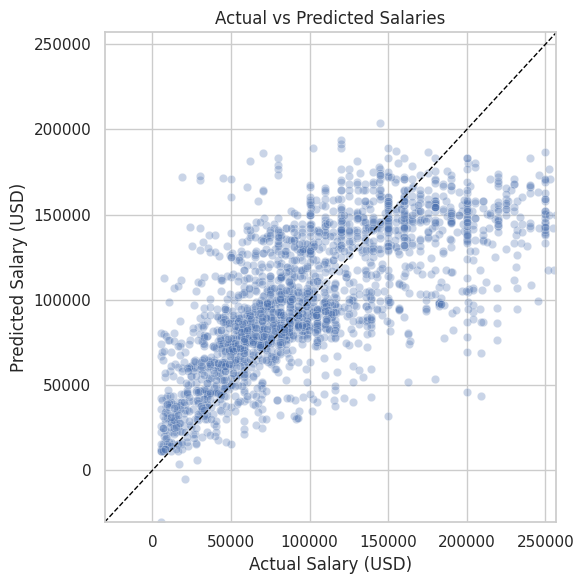

In [21]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_hat, alpha=0.3)
lims = [min(y_val.min(), y_hat.min()), max(y_val.max(), y_hat.max())]
plt.plot(lims, lims, "--", color="black", lw=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Actual vs Predicted Salaries")
plt.tight_layout()
plt.show()


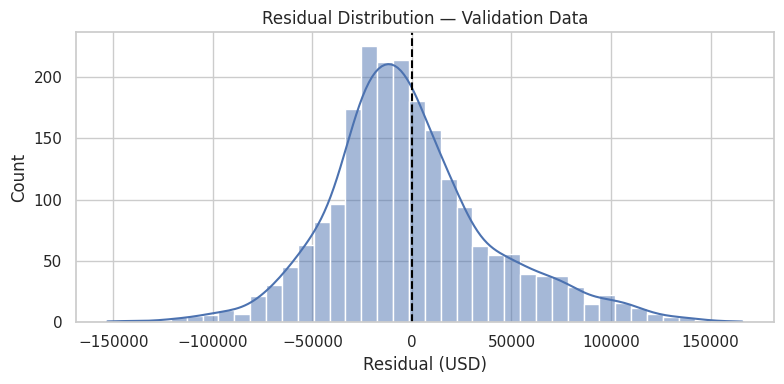

In [22]:
resid = y_val - y_hat

plt.figure(figsize=(8,4))
sns.histplot(resid, bins=40, kde=True)
plt.axvline(0, color="black", ls="--")
plt.xlabel("Residual (USD)")
plt.title("Residual Distribution — Validation Data")
plt.tight_layout()
plt.show()

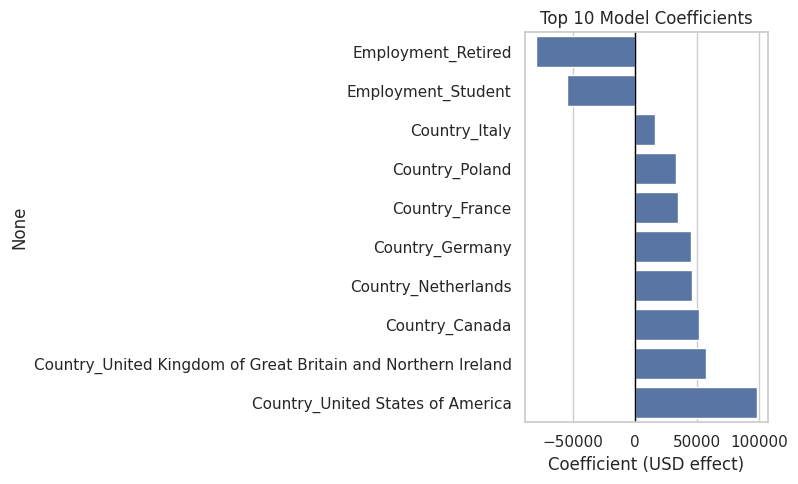

In [23]:
coef_series = pd.Series(lin.coef_, index=X.columns).sort_values(key=lambda s: s.abs(), ascending=False)
topn = 10
coef_top = coef_series.head(topn).sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=coef_top.values, y=coef_top.index)
plt.axvline(0, color="black", lw=1)
plt.xlabel("Coefficient (USD effect)")
plt.title(f"Top {topn} Model Coefficients")
plt.tight_layout()
plt.show()

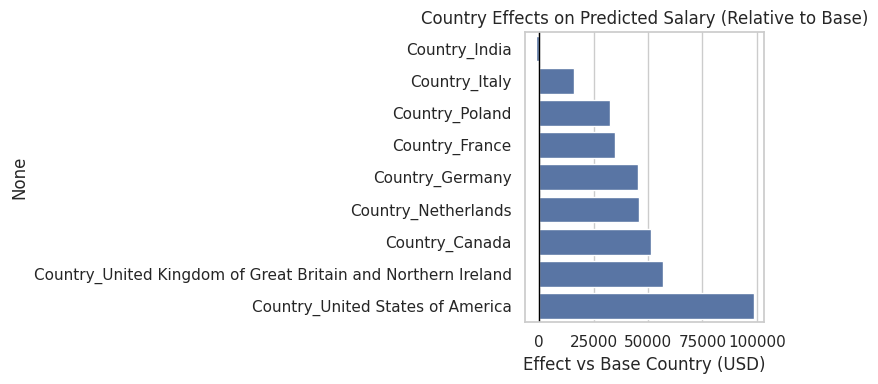

In [24]:
country_cols = [c for c in X.columns if c.startswith("Country_")]
country_coefs = coef_series.loc[country_cols].sort_values()

plt.figure(figsize=(8, max(4, 0.25*len(country_coefs))))
sns.barplot(x=country_coefs.values, y=country_coefs.index)
plt.axvline(0, color="black", lw=1)
plt.xlabel("Effect vs Base Country (USD)")
plt.title("Country Effects on Predicted Salary (Relative to Base)")
plt.tight_layout()
plt.show()


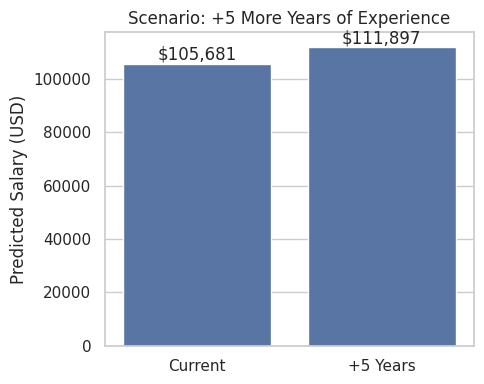

Predicted increase: +$6,216


In [25]:
x0 = X_val.sample(1, random_state=1)
base = lin.predict(x0)[0]

x0_plus5 = x0.copy()
if "YearsCodePro" in x0_plus5.columns:
    x0_plus5["YearsCodePro"] = x0_plus5["YearsCodePro"] + 5
alt = lin.predict(x0_plus5)[0]

plt.figure(figsize=(5,4))
sns.barplot(x=["Current", "+5 Years"], y=[base, alt])
plt.ylabel("Predicted Salary (USD)")
plt.title("Scenario: +5 More Years of Experience")
for i, v in enumerate([base, alt]):
    plt.text(i, v, f"${v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

print(f"Predicted increase: +${alt - base:,.0f}")
